# Flame Speed with Convergence Analysis

In this example we simulate a freely-propagating, adiabatic, 1-D flame and
* Calculate its laminar burning velocity
* Estimate the uncertainty in the laminar burning velocity calculation, due to grid size.

The figure below illustrates the setup, in a flame-fixed co-ordinate system. The reactants enter with density $\rho_{u}$, temperature $T_{u}$ and speed $S_{u}$. The products exit the flame at speed $S_{b}$, density $\rho_{b}$ and temperature $T_{b}$.

<img src="images/flameSpeed.png" alt="Freely Propagating Flame" style="width: 300px;"/>

* Discretization error affects flame speed calculation
* Discretization of the convection term is first order
* Expect the error to be proportional to $\Delta x$, or inversely proportional to the number of grid points ($N$)
  $$S_{u,\mathrm{observed}} = S_{u,\mathrm{true}} + \frac{k}{N}$$
* We can calculate the flame speed on multiple grid sizes, then extrapolate as $N\rightarrow\infty$
* We can estimate the error both with respect to the extrapolated flame speed, and the error in the extrapolation
* Use 1D solver "callback" functions to analyze the grid after each refinement step

### Import Modules

In [1]:
import cantera as ct
import numpy as np
import scipy.optimize
import time
from IPython.display import display, HTML

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2
print(f"Running Cantera version {ct.__version__}")

Running Cantera version 2.4.0


## Estimate uncertainty from grid size and speeds

In [3]:
def extrapolate_uncertainty(grids, speeds, plot=True):
    """
    Given a list of grid sizes and a corresponding list of flame speeds,
    extrapolate and estimate the uncertainty in the final flame speed.
    Also makes a plot.
    """
    grids = list(grids)
    speeds = list(speeds)
    def speed_from_grid_size(grid_size, true_speed, error):
        """
        Given a grid size (or an array or list of grid sizes), return a prediction
        (or array of predictions) of the computed flame speed, based on the parameters
        `true_speed` and `error`        
        """
        return true_speed +  error / np.array(grid_size)

    # Use last 4 grids to extrapolate
    popt, pcov = scipy.optimize.curve_fit(speed_from_grid_size, grids[-4:], speeds[-4:])
    true_speed_estimate = popt[0]
    perr = np.sqrt(np.diag(pcov))

    percent_error_in_true_speed = 100 * perr[0] / true_speed_estimate
    estimated_percent_error = 100 * (speed_from_grid_size(grids[-1], *popt) - true_speed_estimate) / true_speed_estimate
    total_percent_error_estimate = abs(percent_error_in_true_speed) + abs(estimated_percent_error)

    print(f"Fitted true_speed is {popt[0]*100:.4f} ± {perr[0]*100:.4f} cm/s ({percent_error_in_true_speed:.2f}%)")
    print(f"Difference from extrapolated speed {estimated_percent_error:.2f}%")
    print(f"Estimated total error {total_percent_error_estimate:.2f}%")
    
    if not plot:
        return true_speed_estimate, total_percent_error_estimate

    f, ax = plt.subplots(1, 1)
    ax.semilogx(grids, speeds,'o-')
    ax.set_ylim(min(speeds[-5:] + [true_speed_estimate-perr[0]]) * 0.95,
                max(speeds[-5:]+[true_speed_estimate+perr[0]]) * 1.05)
    ax.plot(grids[-4:], speeds[-4:], 'or')
    extrapolated_grids = np.logspace(np.log10(grids[0]), np.log10(8 * grids[-1]), 100)
    ax.plot(extrapolated_grids, speed_from_grid_size(extrapolated_grids, *popt),':r')
    xlims = min(extrapolated_grids), max(extrapolated_grids)
    ax.set_xlim(xlims)
    ax.hlines(true_speed_estimate, *xlims, colors='r', linestyles='dashed')

    ax.hlines([true_speed_estimate-perr[0], true_speed_estimate+perr[0]], *xlims,
              colors='r', linestyles='dashed', alpha=0.3)
    ax.fill_between(xlims, true_speed_estimate-perr[0],true_speed_estimate+perr[0], facecolor='red', alpha=0.1)

    above = popt[1] / abs(popt[1]) # will be +1 if approach from above or -1 if approach from below
    
    local_speed_estimate = speed_from_grid_size(grids[-1], *popt)
    local_err = np.array([[max(true_speed_estimate-local_speed_estimate, 0)],
                          [max(local_speed_estimate-true_speed_estimate, 0)]])
    extrap_err = np.array([[abs(perr[0])], [0]])
    ax.errorbar([grids[-1]], [true_speed_estimate], local_err, capsize=10, color='k', lw=2, capthick=2)
    ax.errorbar([grids[-1]*3], [true_speed_estimate], abs(perr[0]), capsize=10, color='k', lw=2, capthick=2)
        
    ax.annotate(f"{abs(estimated_percent_error):.2f}%",
                xy=(grids[-1], local_speed_estimate),
                xycoords='data',
                xytext=(10,20*above),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3')
                )

    ax.annotate(rf"$\pm${abs(percent_error_in_true_speed):.2f}%",
                xy=(grids[-1]*3, true_speed_estimate-abs(perr[0])),
                xycoords='data',
                xytext=(10,-20*above),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->',
                                connectionstyle='arc3')
                )

    ax.set(ylabel="Flame speed (m/s)", xlabel="Grid size")
    plt.show()
    
    return true_speed_estimate, total_percent_error_estimate

In [4]:
def make_callback(flame):
    speeds = []
    grids = []

    def callback(_):
        speed = flame.u[0]
        grid = len(flame.grid)
        speeds.append(speed)
        grids.append(grid)
        print(f"Iteration {len(grids)} ({grids[-1]} points). Current flame speed is is {speed*100:.4f} cm/s")
        if len(grids) < 5:
            return 1.0 # 
        try:
            extrapolate_uncertainty(grids, speeds)
        except Exception as e:
            print("Couldn't estimate uncertainty. " + str(e))
            return 1.0 # continue anyway

        return 1.0
    return callback, speeds, grids


### Define the gas mixture and kinetic mechanism

In [5]:
gas = ct.Solution('input-files/gri30_noNOx.cti')

### Set flame simulation conditions and solver properties

In [6]:
# Temperature and pressure
To = 300
Po = ct.one_atm

# Domain width in meters
width = 0.06

# Set the gas to be a stoichiometric CH4/air mixture 
gas.set_equivalence_ratio(0.9, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

# Disable logging
loglevel = 0

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Define tight tolerances for the solver
flame.set_refine_criteria(ratio=2, slope=0.01, curve=0.01)

# Set maxiumum number of grid points to be very high (otherwise default is 1000)
flame.set_max_grid_points(flame.flame, 10000)

# Set up the the callback function and lists of speeds and grids
callback, speeds, grids = make_callback(flame)
flame.set_steady_callback(callback)

### Solve

Iteration 1 (9 points). Current flame speed is is 8.5059 cm/s
Iteration 2 (9 points). Current flame speed is is 8.5059 cm/s
Iteration 3 (16 points). Current flame speed is is 19.5977 cm/s
Iteration 4 (28 points). Current flame speed is is 38.4353 cm/s
Iteration 5 (46 points). Current flame speed is is 25.2143 cm/s
Fitted true_speed is 37.9555 ± 8.5280 cm/s (22.47%)
Difference from extrapolated speed -14.89%
Estimated total error 37.36%


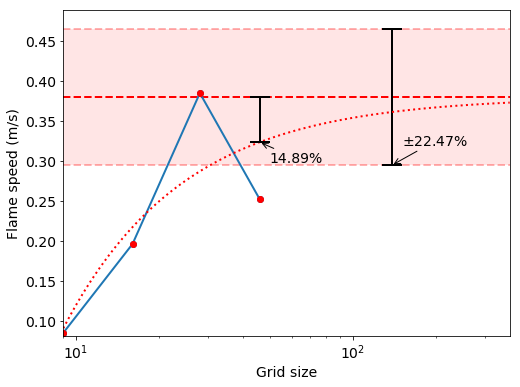

Iteration 6 (71 points). Current flame speed is is 35.9921 cm/s
Fitted true_speed is 38.2547 ± 9.0259 cm/s (23.59%)
Difference from extrapolated speed -9.28%
Estimated total error 32.87%


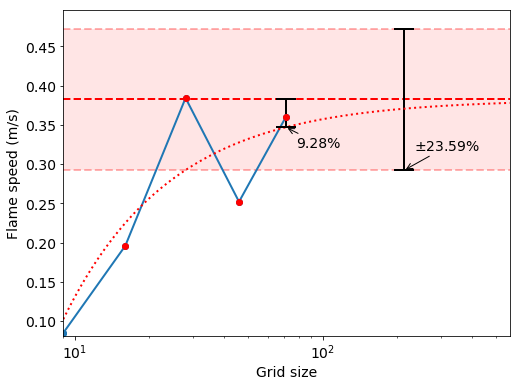

Iteration 7 (107 points). Current flame speed is is 33.9821 cm/s
Fitted true_speed is 31.2050 ± 7.7749 cm/s (24.92%)
Difference from extrapolated speed 3.26%
Estimated total error 28.18%


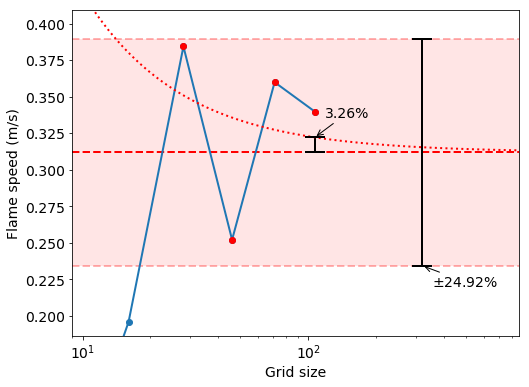

Iteration 8 (157 points). Current flame speed is is 33.5283 cm/s
Fitted true_speed is 39.0859 ± 4.6652 cm/s (11.94%)
Difference from extrapolated speed -8.74%
Estimated total error 20.67%


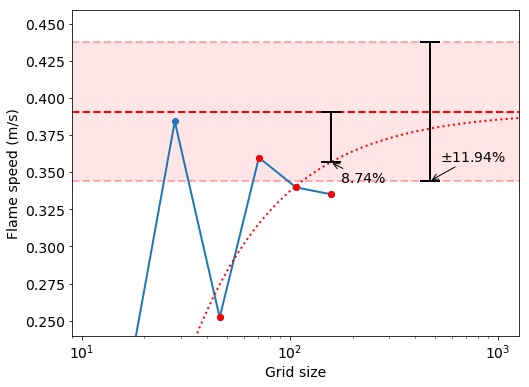

Iteration 9 (216 points). Current flame speed is is 33.4054 cm/s
Fitted true_speed is 31.8280 ± 0.5427 cm/s (1.71%)
Difference from extrapolated speed 4.05%
Estimated total error 5.76%


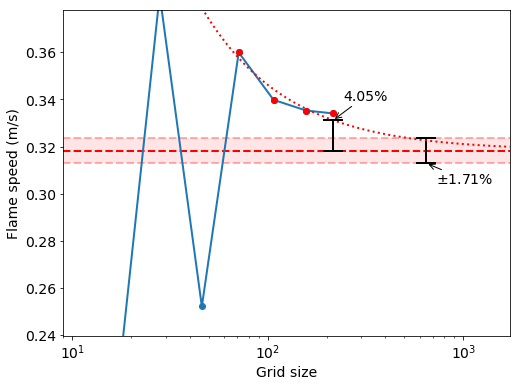

Iteration 10 (295 points). Current flame speed is is 33.3895 cm/s
Fitted true_speed is 32.9648 ± 0.1366 cm/s (0.41%)
Difference from extrapolated speed 1.06%
Estimated total error 1.47%


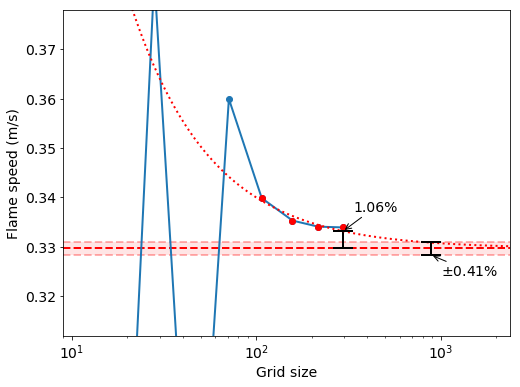

Iteration 11 (392 points). Current flame speed is is 33.4064 cm/s
Fitted true_speed is 33.2919 ± 0.0636 cm/s (0.19%)
Difference from extrapolated speed 0.25%
Estimated total error 0.45%


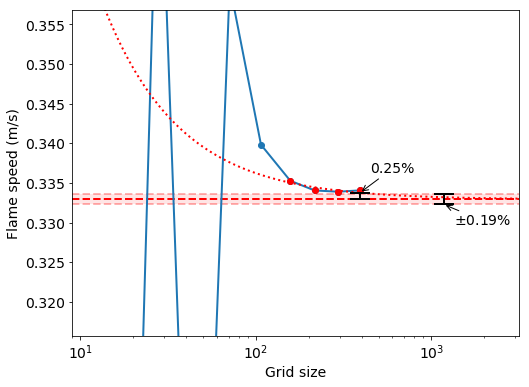

Iteration 12 (530 points). Current flame speed is is 33.4367 cm/s
Fitted true_speed is 33.4417 ± 0.0304 cm/s (0.09%)
Difference from extrapolated speed -0.06%
Estimated total error 0.15%


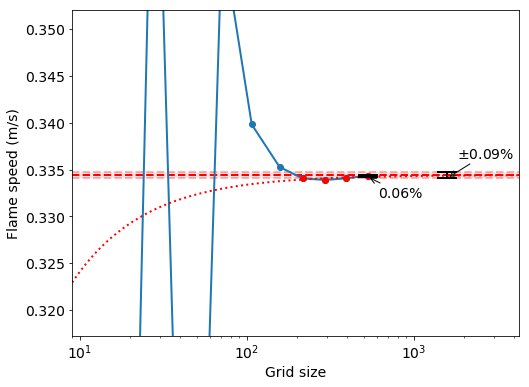

Iteration 13 (748 points). Current flame speed is is 33.4604 cm/s
Fitted true_speed is 33.5036 ± 0.0110 cm/s (0.03%)
Difference from extrapolated speed -0.14%
Estimated total error 0.17%


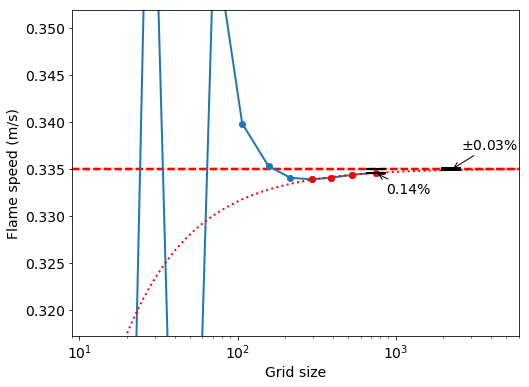

Iteration 14 (988 points). Current flame speed is is 33.4858 cm/s
Fitted true_speed is 33.5320 ± 0.0074 cm/s (0.02%)
Difference from extrapolated speed -0.15%
Estimated total error 0.17%


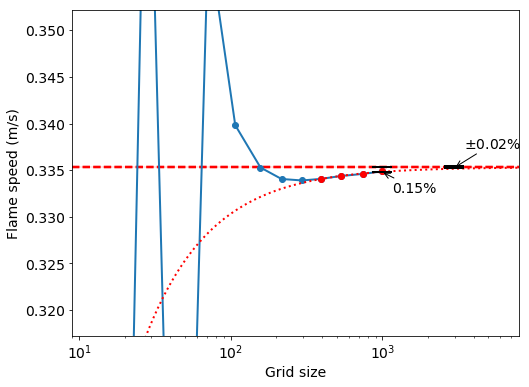

Iteration 15 (989 points). Current flame speed is is 33.4884 cm/s
Fitted true_speed is 33.5439 ± 0.0095 cm/s (0.03%)
Difference from extrapolated speed -0.17%
Estimated total error 0.20%


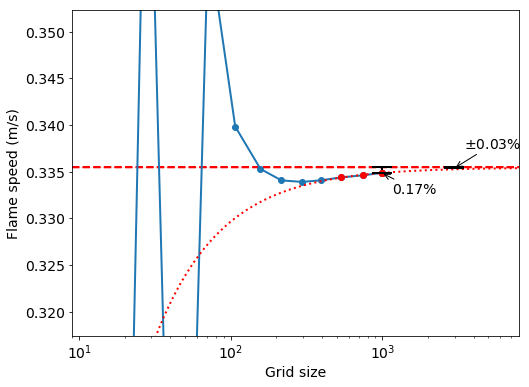

In [7]:
flame.solve(loglevel=loglevel, auto=True)

Fitted true_speed is 33.5439 ± 0.0095 cm/s (0.03%)
Difference from extrapolated speed -0.17%
Estimated total error 0.20%


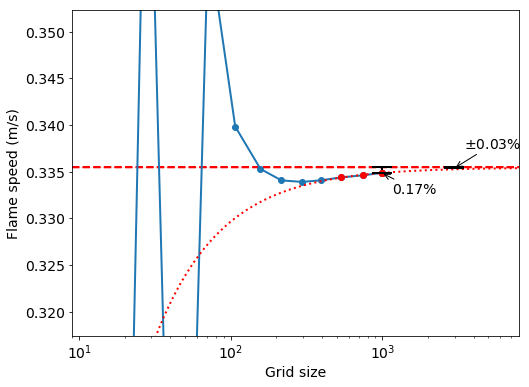

In [8]:
best_true_speed_estimate, best_total_percent_error_estimate =  extrapolate_uncertainty(grids, speeds)

In [9]:
def analyze_errors(grids, speeds):
    true_speed_estimates = []
    total_percent_error_estimates = []
    actual_extrapolated_percent_errors = []
    actual_raw_percent_errors = []
    for i in range(3, len(grids)):
        print(f"{grids[i]} point grid:")
        true_speed_estimate, total_percent_error_estimate = extrapolate_uncertainty(grids[:i+1], speeds[:i+1], plot=False)
        actual_extrapolated_percent_error = 100 * abs(true_speed_estimate - best_true_speed_estimate) / best_true_speed_estimate
        actual_raw_percent_error = 100 * abs(speeds[i] - best_true_speed_estimate) / best_true_speed_estimate
        print(f"Actual extrapolated error (with hindsight) {actual_extrapolated_percent_error:.1f}%")
        print(f"Actual raw error (with hindsight) {actual_raw_percent_error:.1f}%")

        true_speed_estimates.append(true_speed_estimate)
        total_percent_error_estimates.append(total_percent_error_estimate)
        actual_extrapolated_percent_errors.append(actual_extrapolated_percent_error)
        actual_raw_percent_errors.append(actual_raw_percent_error)
        print()

    f, ax = plt.subplots()
    ax.loglog(grids[3:], actual_raw_percent_errors,'o-', label='raw error')
    ax.loglog(grids[3:], actual_extrapolated_percent_errors,'o-', label='extrapolated error')
    ax.loglog(grids[3:], total_percent_error_estimates,'o-', label='estimated error')
    ax.set(ylabel="Error in flame speed (%)", xlabel="Grid size", title=flame.get_refine_criteria())
    ax.yaxis.set_major_formatter
    ax.legend()

28 point grid:
Fitted true_speed is 47.8076 ± 6.3594 cm/s (13.30%)
Difference from extrapolated speed -27.09%
Estimated total error 40.39%
Actual extrapolated error (with hindsight) 42.5%
Actual raw error (with hindsight) 14.6%

46 point grid:
Fitted true_speed is 37.9555 ± 8.5280 cm/s (22.47%)
Difference from extrapolated speed -14.89%
Estimated total error 37.36%
Actual extrapolated error (with hindsight) 13.2%
Actual raw error (with hindsight) 24.8%

71 point grid:
Fitted true_speed is 38.2547 ± 9.0259 cm/s (23.59%)
Difference from extrapolated speed -9.28%
Estimated total error 32.87%
Actual extrapolated error (with hindsight) 14.0%
Actual raw error (with hindsight) 7.3%

107 point grid:
Fitted true_speed is 31.2050 ± 7.7749 cm/s (24.92%)
Difference from extrapolated speed 3.26%
Estimated total error 28.18%
Actual extrapolated error (with hindsight) 7.0%
Actual raw error (with hindsight) 1.3%

157 point grid:
Fitted true_speed is 39.0859 ± 4.6652 cm/s (11.94%)
Difference from extra

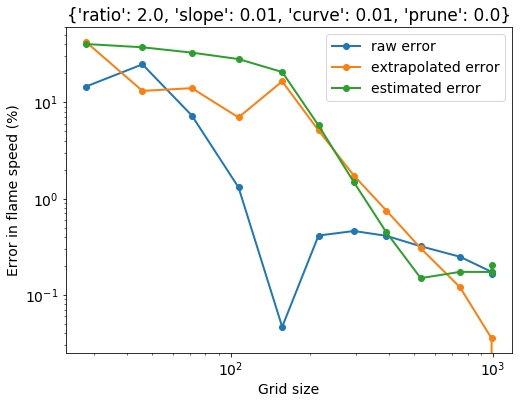

In [10]:
analyze_errors(grids, speeds)

## Middling refine criteria

In [11]:
refine_criteria = {'ratio':3, 'slope': 0.1, 'curve': 0.1}

Iteration 1 (9 points). Current flame speed is is 8.5059 cm/s
Iteration 2 (9 points). Current flame speed is is 8.5059 cm/s
Iteration 3 (15 points). Current flame speed is is 19.5976 cm/s
Iteration 4 (23 points). Current flame speed is is 38.4354 cm/s
Iteration 5 (31 points). Current flame speed is is 25.2267 cm/s
Fitted true_speed is 41.6667 ± 9.9221 cm/s (23.81%)
Difference from extrapolated speed -22.87%
Estimated total error 46.69%


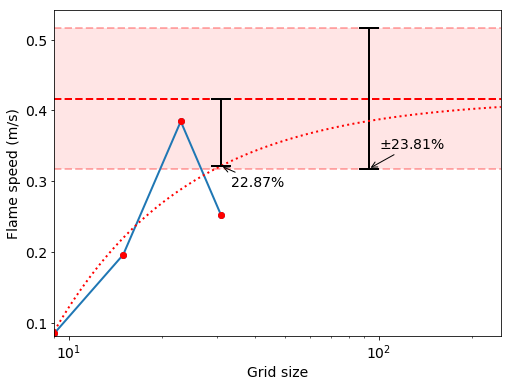

Iteration 6 (40 points). Current flame speed is is 36.0127 cm/s
Fitted true_speed is 42.4412 ± 12.1874 cm/s (28.72%)
Difference from extrapolated speed -17.77%
Estimated total error 46.48%


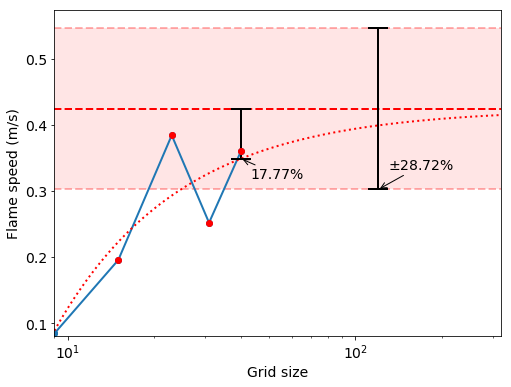

Iteration 7 (51 points). Current flame speed is is 34.0500 cm/s
Fitted true_speed is 30.6474 ± 12.2031 cm/s (39.82%)
Difference from extrapolated speed 5.92%
Estimated total error 45.74%


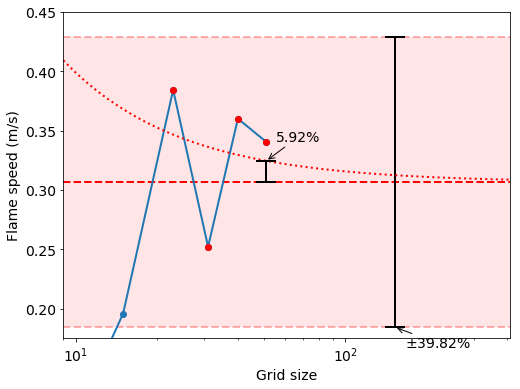

Iteration 8 (64 points). Current flame speed is is 33.6782 cm/s
Fitted true_speed is 43.2618 ± 7.8512 cm/s (18.15%)
Difference from extrapolated speed -17.21%
Estimated total error 35.36%


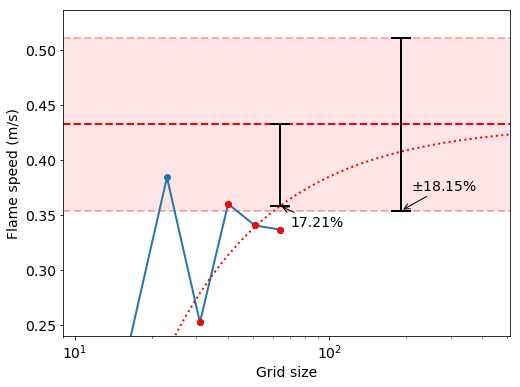

Iteration 9 (82 points). Current flame speed is is 33.7101 cm/s
Fitted true_speed is 31.0830 ± 1.1891 cm/s (3.83%)
Difference from extrapolated speed 7.11%
Estimated total error 10.93%


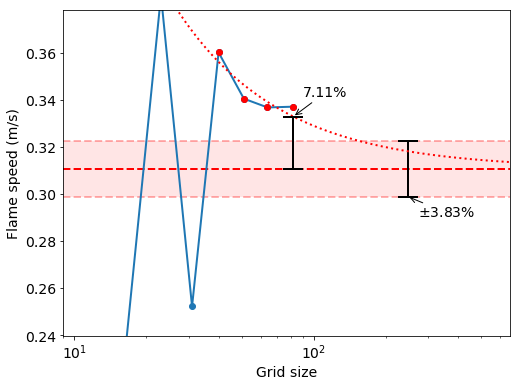

Iteration 10 (108 points). Current flame speed is is 33.9344 cm/s
Fitted true_speed is 33.6772 ± 0.3984 cm/s (1.18%)
Difference from extrapolated speed 0.32%
Estimated total error 1.50%


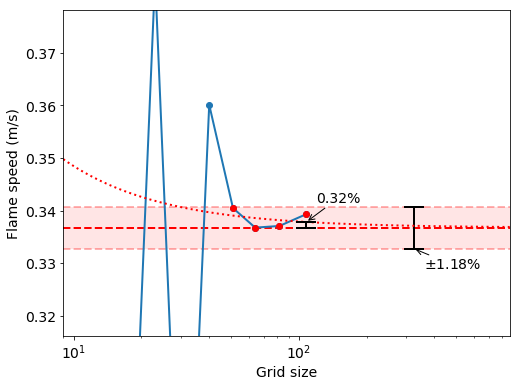

Iteration 11 (136 points). Current flame speed is is 34.2040 cm/s
Fitted true_speed is 34.5673 ± 0.2205 cm/s (0.64%)
Difference from extrapolated speed -1.31%
Estimated total error 1.95%


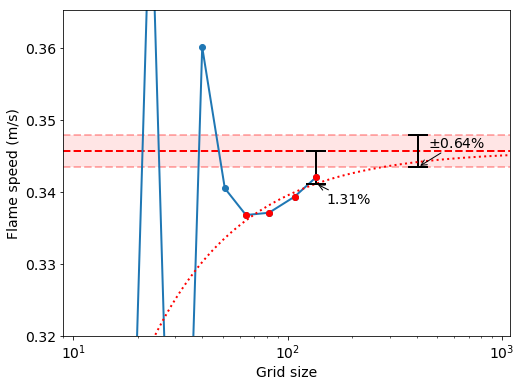

In [12]:
# Reset the gas
gas.set_equivalence_ratio(0.9, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

# Create a new flame object
flame = ct.FreeFlame(gas, width=width)

flame.set_refine_criteria(**refine_criteria)
flame.set_max_grid_points(flame.flame, 1e4)

callback, speeds, grids = make_callback(flame)
flame.set_steady_callback(callback)

flame.solve(loglevel=loglevel, auto=True)


23 point grid:
Fitted true_speed is 52.0985 ± 7.4922 cm/s (14.38%)
Difference from extrapolated speed -33.48%
Estimated total error 47.86%
Actual extrapolated error (with hindsight) 55.3%
Actual raw error (with hindsight) 14.6%

31 point grid:
Fitted true_speed is 41.6667 ± 9.9221 cm/s (23.81%)
Difference from extrapolated speed -22.87%
Estimated total error 46.69%
Actual extrapolated error (with hindsight) 24.2%
Actual raw error (with hindsight) 24.8%

40 point grid:
Fitted true_speed is 42.4412 ± 12.1874 cm/s (28.72%)
Difference from extrapolated speed -17.77%
Estimated total error 46.48%
Actual extrapolated error (with hindsight) 26.5%
Actual raw error (with hindsight) 7.4%

51 point grid:
Fitted true_speed is 30.6474 ± 12.2031 cm/s (39.82%)
Difference from extrapolated speed 5.92%
Estimated total error 45.74%
Actual extrapolated error (with hindsight) 8.6%
Actual raw error (with hindsight) 1.5%

64 point grid:
Fitted true_speed is 43.2618 ± 7.8512 cm/s (18.15%)
Difference from extr

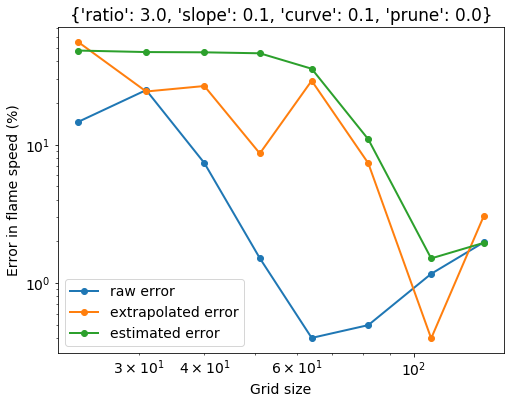

In [13]:
analyze_errors(grids, speeds)